# Modelling via scikit-learn

This notebook performs model fitting and evaluating on hold out areas, using models from scikit-learn.

## Imports and Setup

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from math import sqrt
import pathlib
import os
from sklearn.externals import joblib

from sklearn.ensemble import RandomForestRegressor
from scipy.stats import pearsonr
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
# pd.reset_option('^display')

# ignore warnings
import logging
import warnings
logging.getLogger().setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

import sys
sys.path.insert(0, '../utils')
import modelutils
from settings import *

/opt/conda/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


## File Locations

In [2]:
dirs = [model_dir, scaler_dir, preds_dir]
for dir_ in dirs:
    with pathlib.Path(dir_) as path:
        if not path.exists():
            path.mkdir(parents=True, exist_ok=True)

## Load Data

In [3]:
# !gsutil cp gs://immap-wash-training/training/20200916_*.csv {data_dir}
df = pd.read_csv(data_dir + '20200916_dataset.csv')
df['population'] = df['population'].fillna(0)
df = df.dropna().reset_index(drop = True)
df.shape

(57036, 45)

## Fit, Predict and Evaluate Models Using 5-fold Cross Validation
Trains a random forest model to predict each of the 3 WASH indicators, setting random 20% of the data (whichever the area) as test data and everything else as training data. The train-test split is done for 5 different folds.

### Using Both Urban and Rural Dataset

In [4]:
# from sklearn.ensemble import RandomForestRegressor
# clf = RandomForestRegressor(random_state=42)

# res = modelutils.fit_with_randomsplit(df, clf, features, indicators, scale = True, n_splits = 5, prefix = 'all_250mv2')
res = pd.read_csv(data_dir + 'all_250mv2_randomsplit_results.csv')
modelutils.average_results(res, iterate_over = 'split_id', prefix = 'all_250mv2')

Access to water
correlation    0.772267
r2             0.596589
rmse           0.129155
dtype: float64
Access to toilet
correlation    0.731977
r2             0.535973
rmse           0.123311
dtype: float64
Access to sewage
correlation    0.804580
r2             0.647380
rmse           0.170705
dtype: float64


Access to water
1
Number of test samples: 11408
	correlation: 0.7587
	r2: 0.5756
	mae: 0.0627
	rmse: 0.1302


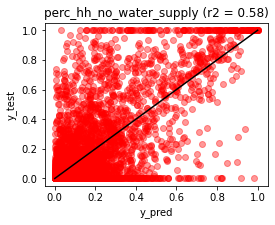

2
Number of test samples: 11407
	correlation: 0.7597
	r2: 0.5771
	mae: 0.0635
	rmse: 0.1322


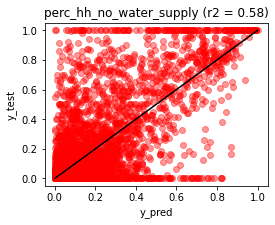

3
Number of test samples: 11407
	correlation: 0.7686
	r2: 0.5908
	mae: 0.0630
	rmse: 0.1298


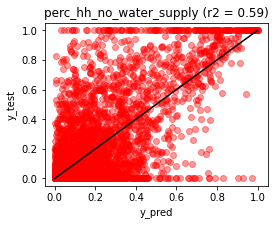

4
Number of test samples: 11407
	correlation: 0.7962
	r2: 0.6340
	mae: 0.0620
	rmse: 0.1266


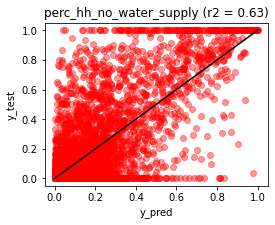

5
Number of test samples: 11407
	correlation: 0.7780
	r2: 0.6053
	mae: 0.0625
	rmse: 0.1271


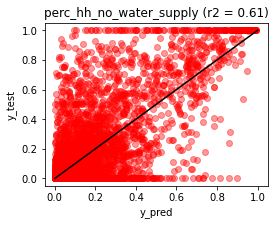


Average Metrics
correlation: 0.7780
r2: 0.6053
mae: 0.0625
rmse: 0.1271

Consolidated Metrics
correlation: 0.7726
r2: 0.5969
mae: 0.0627
rmse: 0.1292



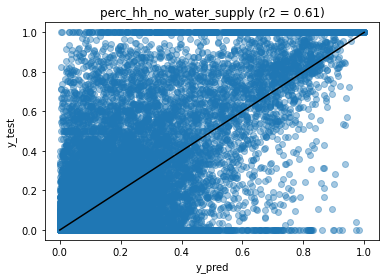

Access to toilet
1
Number of test samples: 11408
	correlation: 0.7203
	r2: 0.5188
	mae: 0.0591
	rmse: 0.1231


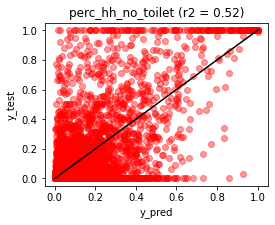

2
Number of test samples: 11407
	correlation: 0.7161
	r2: 0.5129
	mae: 0.0595
	rmse: 0.1251


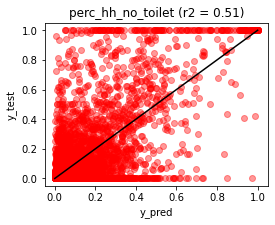

3
Number of test samples: 11407
	correlation: 0.7403
	r2: 0.5481
	mae: 0.0584
	rmse: 0.1208


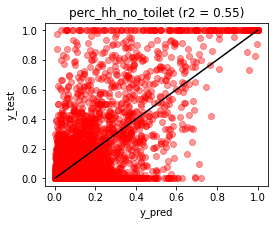

4
Number of test samples: 11407
	correlation: 0.7532
	r2: 0.5674
	mae: 0.0585
	rmse: 0.1230


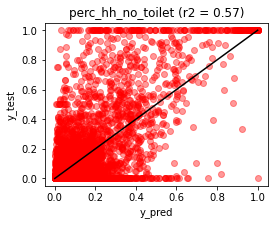

5
Number of test samples: 11407
	correlation: 0.7299
	r2: 0.5328
	mae: 0.0602
	rmse: 0.1246


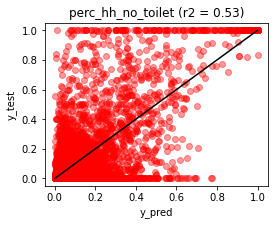


Average Metrics
correlation: 0.7299
r2: 0.5328
mae: 0.0602
rmse: 0.1246

Consolidated Metrics
correlation: 0.7321
r2: 0.5360
mae: 0.0591
rmse: 0.1233



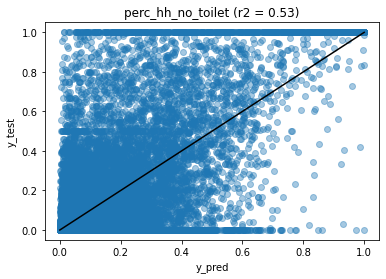

Access to sewage
1
Number of test samples: 11408
	correlation: 0.8002
	r2: 0.6403
	mae: 0.0972
	rmse: 0.1710


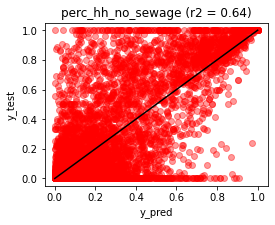

2
Number of test samples: 11407
	correlation: 0.8018
	r2: 0.6428
	mae: 0.0984
	rmse: 0.1736


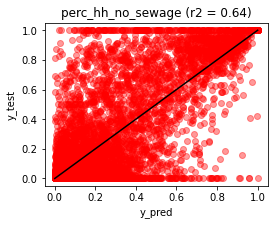

3
Number of test samples: 11407
	correlation: 0.8116
	r2: 0.6586
	mae: 0.0969
	rmse: 0.1684


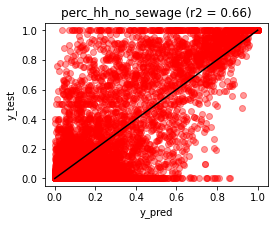

4
Number of test samples: 11407
	correlation: 0.8111
	r2: 0.6578
	mae: 0.0965
	rmse: 0.1695


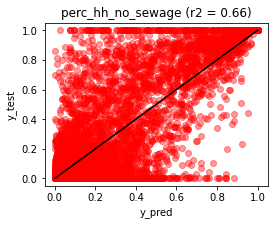

5
Number of test samples: 11407
	correlation: 0.7983
	r2: 0.6373
	mae: 0.0977
	rmse: 0.1710


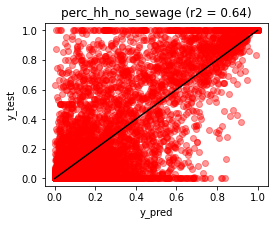


Average Metrics
correlation: 0.7983
r2: 0.6373
mae: 0.0977
rmse: 0.1710

Consolidated Metrics
correlation: 0.8046
r2: 0.6474
mae: 0.0973
rmse: 0.1707



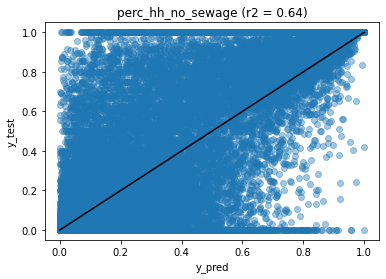

In [4]:
# from sklearn.ensemble import RandomForestRegressor
# clf = RandomForestRegressor(random_state=42)

# res = modelutils.fit_with_randomsplit(df, clf, features, indicators, scale = True, n_splits = 5, prefix = 'all_250mv2')
res = pd.read_csv(data_dir + 'all_250mv2_randomsplit_results.csv')
modelutils.average_results(res, iterate_over = 'split_id', prefix = 'all_250mv2')

In [5]:
res.head(1)

,Unnamed: 0,split_id,indicator,grid_id,adm1_name,y_true,y_pred
0,0,1,perc_hh_no_water_supply,41026516,Amazonas,0.878788,0.422387


In [13]:
# clf = RandomForestRegressor(random_state=42)

# res = fit_with_randomsplit(df, clf, features, indicators, scale = True, n_splits = 5, prefix = 'all')
res = pd.read_csv(data_dir + 'all_randomsplit_results.csv')
met = modelutils.average_results(res, iterate_over = 'split_id', prefix = 'all')

Access to water
correlation    0.772267
r2             0.596589
rmse           0.129155
dtype: float64
Access to toilet
correlation    0.731977
r2             0.535973
rmse           0.123311
dtype: float64
Access to sewage
correlation    0.804580
r2             0.647380
rmse           0.170705
dtype: float64


In [10]:
met

In [10]:
pearsonr(res['y_true'], res['y_pred'])[0]**2

0.6215550756716262

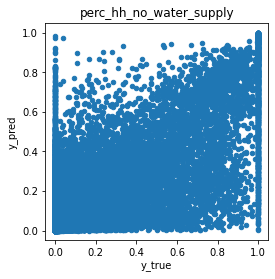

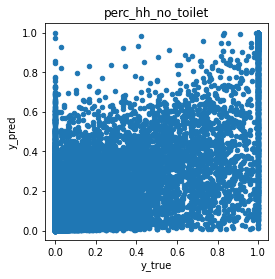

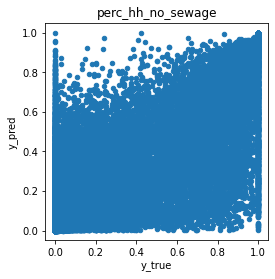

In [11]:
for indicator in indicators:
    (res.query(f"indicator == '{indicator}'")
     .plot(x = 'y_true', y = 'y_pred', figsize = (4,4), kind = 'scatter', title = indicator))